In [1]:
import numpy as np
import openmm as mm
import mdtraj as md
from openmm import unit
import openmm.app as app
import os
from openmmtools import states, mcmc
import openmmtools
import os
import os.path as osp
from ReplicaExchangeProtocol import ReplicaExchange
import time


if osp.exists('output-1.nc'): os.system('rm output-1.nc')

# System creation
# Define force field
forcefield=['amber99sbildn.xml','tip3p.xml']
constraints = app.HBonds
nonbonded_cutoff = 0.9*unit.nanometer
switch_distance = 0.75*unit.nanometer
nonbonded_method = app.PME
implicit_solvent = False
solvated = True
hydrogen_mass = None

# Define initial constants of the input pdb file
friction = 0.1 / unit.picoseconds
pressure = 1.0 * unit.atmosphere
temperature = 300*unit.kelvin
timestep = 2.0 * unit.femtosecond

# Load pdb file 
pdb = app.PDBFile('chi_sys.pdb')
modeller = app.modeller.Modeller(pdb.topology, pdb.positions)

# Define system 
create_system_kwargs = dict(
    removeCMMotion=True,
    nonbondedMethod=nonbonded_method,
    nonbondedCutoff=nonbonded_cutoff,
    switchDistance=switch_distance,
    constraints=constraints,
    hydrogenMass=hydrogen_mass,
    rigidWater=True,
)


ff = app.ForceField(*forcefield)
# Add solvent
#modeller.addSolvent(ff)

# Create a system
system = ff.createSystem(modeller.topology, **create_system_kwargs)

#barostat = mm.MonteCarloBarostat(pressure, temperature)
#force_id = system.addForce(barostat)


platform = mm.Platform.getPlatformByName("CUDA")
platform_properties = {"DeviceIndex": "0", "Precision": "mixed"}

# Replica setup
n_replicas = 36
min_T = 280
max_T = 400
Temps = np.geomspace(min_T, max_T, n_replicas)

protocol = {'temperature': Temps * unit.kelvin}
thermodynamic_states = states.create_thermodynamic_state_protocol(system,protocol)

sampler_states = list()
for i_t,_ in enumerate(thermodynamic_states):
    sampler_states.append(openmmtools.states.SamplerState(positions=modeller.positions))

langevin_move = mcmc.LangevinSplittingDynamicsMove(
    timestep = timestep,
    collision_rate = friction,
    n_steps = 500, # 1ps
    reassign_velocities=False,
    n_restart_attempts=20,
    splitting="V R O R V"
)

# Define class for replica exchange
parallel_tempering = ReplicaExchange(
    thermodynamic_states=thermodynamic_states, 
    sampler_states=sampler_states, 
    mcmc_move=langevin_move,
    rescale_velocities=True,
)


In [18]:
from os import mkdir
Temperatures = [280,283,286,289,292,295,298,301,304,307,310,313,316,320,323,326,330,333,336,340,343,347,350,354,358,361,365,369,372,376,380,384,388,392,396,400]

#PATH =  '/local_scratch2/jacopo/trans_temp/all_atom_replica_results_chignolin/exchange_neighbors/coords_nowater/'
PATH =  '/local_scratch2/jacopo/trans_temp/all_atom_replica_results_chignolin/exchange_neighbors/forces_nowater/'
for t in Temperatures:
    mkdir(f'{PATH}temperature_{t}')

In [15]:
position.shape


(10, 3)

In [8]:
import numpy as np 

acceptance = np.load('acceptance1.npy')
print(np.diag(acceptance,1) / np.diag(acceptance,-1))
print(acceptance)

[0.00920245 0.05521472 0.02167183 0.02312139 0.03809524]
[[  0.   3.   3.   5.  12.   7.]
 [326.   0.  18.  10.   7.  15.]
 [350. 326.   0.   7.   3.   2.]
 [337. 317. 323.   0.   8.   7.]
 [337. 369. 357. 346.   0.  12.]
 [338. 340. 341. 278. 315.   0.]]


In [21]:
a = 
i = np.sort(np.random.choice(range(10),1,replace=False))
j = i + 1
k = i - 1

neighs = a[abs(a - r) == 1]


SyntaxError: invalid syntax (1100248564.py, line 5)

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("equilibration_time_test/log.csv")
#data = data.iloc[:200]

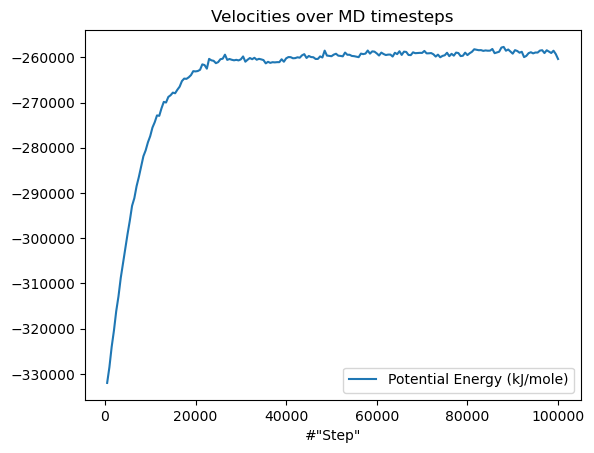

In [57]:
data.plot(0, 1)
plt.title('Velocities over MD timesteps')

plt.show()

#plt.savefig('energy')

Text(0.5, 1.0, 'Velocities over MD timesteps')

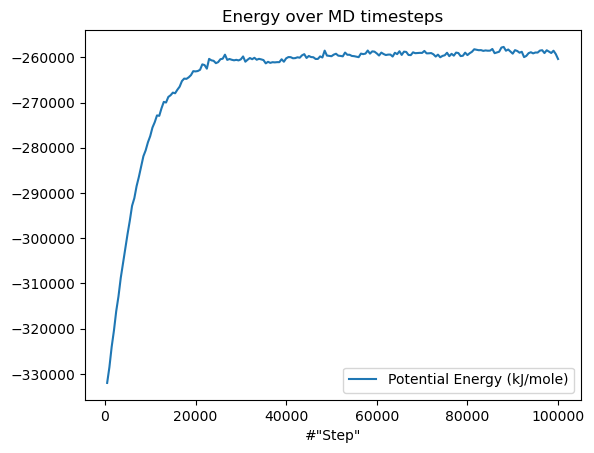

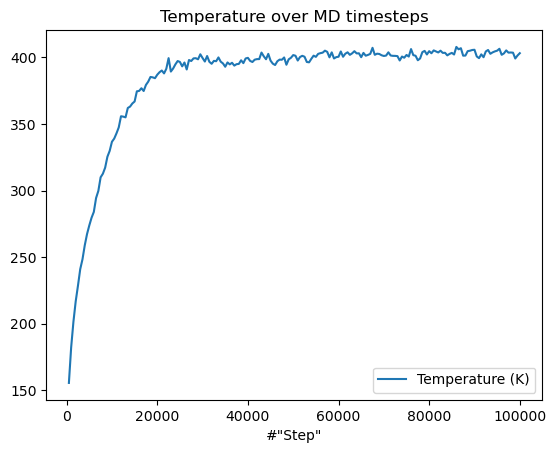

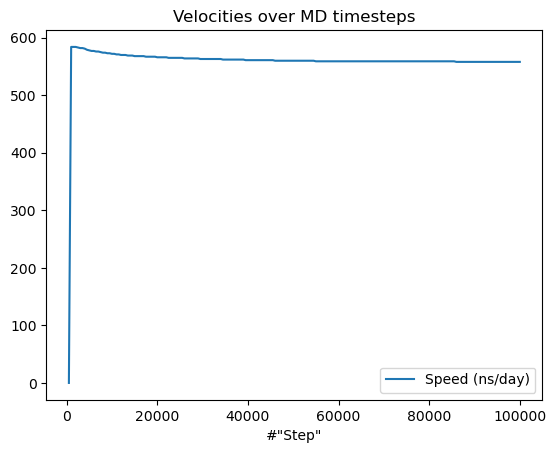

In [58]:
data.plot(0, 1)
plt.title('Energy over MD timesteps')
#plt.savefig('energy_without_rescaling')

data.plot(0, 2)
plt.title('Temperature over MD timesteps')
#plt.savefig('temperature_without_rescaling')


data.plot(0, 3)
plt.title('Velocities over MD timesteps')
#plt.savefig('velocities_without_rescaling')


In [31]:
! nvidia-smi

Fri Jan 13 17:56:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.85.02    Driver Version: 510.85.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   58C    P2   108W / 350W |   2253MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [41]:
50000*2e-3

100.0